# Detect disturbed tress

## Packages and Data

In [17]:
import os
import sys
import seaborn

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.data_loader import DataLoader
from utils.calculate_indices import CalculateIndices
from utils.correlation_analysis import CorrelationAnalysis

In [19]:
dataloader = DataLoader()
df_base = dataloader.load_transform("../../data/Trainings_Datensatz.csv")
df = dataloader.date_feature_extraction(df_base)
df = dataloader.feature_extraction(df)

In [20]:
calculateindices = CalculateIndices()
df = calculateindices.add_all_indices(df)

In [21]:
df

,time,id,disturbance_year,doy,b2,b3,b4,b5,b6,b7,...,ndvi,gndvi,wdvi,tndvi,savi,ipvi,mcari,reip,masvi2,dvi
808190,2017-03-13,1,0,72,147,204,145,400,1193,1435,...,0.833142,0.751068,1520.5,1.154617,1.249353,0.916571,562.758621,-32.156368,-0.999372,1448
808191,2017-03-27,1,0,86,137,222,154,389,1247,1561,...,0.819988,0.750981,1480.0,1.148907,1.229623,0.909994,474.883117,-32.434732,-0.999358,1403
808192,2017-04-09,1,0,99,160,248,169,395,1209,1454,...,0.801059,0.708578,1445.5,1.140640,1.201236,0.900530,422.579882,-31.197789,-0.999347,1361
808193,2017-04-22,1,0,112,146,247,152,391,1354,1628,...,0.833333,0.736533,1596.0,1.154701,1.249657,0.916667,491.836842,-30.333333,-0.999402,1520
808194,2017-04-29,1,0,119,171,264,186,419,1353,1731,...,0.813253,0.735338,1713.0,1.145973,1.219573,0.906627,419.901075,-32.782655,-0.999446,1620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3311855,2022-09-05,28212,0,248,318,450,338,619,1664,2012,...,0.740897,0.634444,2102.0,1.113956,1.111132,0.870448,411.689941,-31.960766,-0.999560,1933
3311856,2022-09-24,28212,0,267,202,334,229,513,1666,2136,...,0.815024,0.729555,2132.5,1.146745,1.222290,0.907512,508.967686,-32.916739,-0.999555,2018
3311857,2022-10-03,28212,0,276,184,311,205,504,1580,1910,...,0.813382,0.719946,1889.5,1.146029,1.219795,0.906691,588.081951,-31.509294,-0.999498,1787
3311858,2022-10-27,28212,0,300,353,560,362,732,1944,2254,...,0.749654,0.601990,2349.0,1.117879,1.124287,0.874827,598.541436,-31.247525,-0.999605,2168


## Analysis stdv of indices 

In [22]:
index = "b11"
df_notdisturbed = df[df["is_disturbed"]==False]
df_yearly = df_notdisturbed.groupby(["id", "year"])[index].mean().reset_index()
std_df = df_yearly.groupby("id")[index].std().reset_index().sort_values(index, ascending=False)
std_df

,id,b11
8628,9953,1985.406956
15231,17514,1949.877801
5359,6186,1202.657025
20048,23033,931.800026
18295,21008,927.819242
...,...,...
10489,12119,7.826386
20772,23866,7.604501
14739,16955,7.444818
19310,22185,7.156948


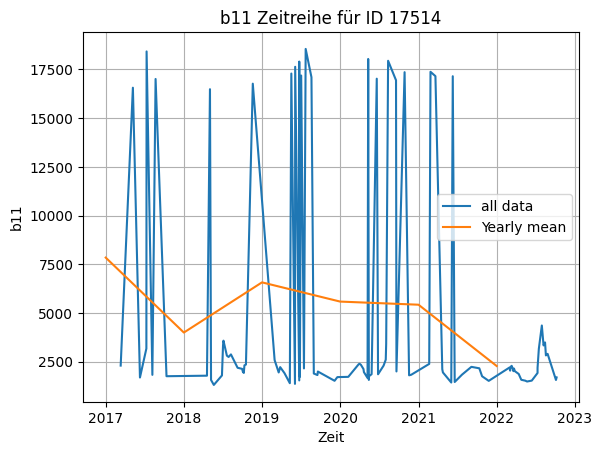

In [23]:
id = 17514
df_sub = df[df["id"] == id]

df_yearly_sub = df_yearly[df_yearly["id"] == id]
df_yearly_sub = df_yearly[df_yearly["id"] == id].copy()
df_yearly_sub["year_dt"] = pd.to_datetime(df_yearly_sub["year"].astype(str) + "-01-01")

plt.plot(df_sub["time"], df_sub[index], label="all data")
plt.plot(df_yearly_sub["year_dt"], df_yearly_sub[index], label="Yearly mean")

plt.title(f"{index} Zeitreihe für ID {id}")
plt.xlabel("Zeit")
plt.ylabel(index)
plt.legend()
plt.grid(True)
plt.show()

## Calculate std deviation for every index column
1. Normalize columns so that those with higher ranges do not have a greater influence
2. Group by year and compute the mean of each index column
3. Compute the standard deviation of the yearly values
4. Join column "is_disturbed" to the resulting df

In [24]:
indices = ["b2", "b3", "b4", "b5", "b6", "b7", "b8", "b8a", "b11", "b12", "ndvi", "gndvi", "wdvi", "tndvi", "savi", "ipvi", "mcari", "reip", "masvi2", "dvi"]

In [25]:
df_norm = df.copy()
df_norm[indices] = (df[indices] - df[indices].min()) / (df[indices].max() - df[indices].min())

In [26]:
df_yearly = df_norm.groupby(["id", "year"])[indices].mean().reset_index()
std_df = df_yearly.groupby("id")[indices].std().reset_index()
std_df = std_df.rename(columns={col: f"{col}_stdv" for col in indices})

df_disturbance = df.groupby("id")["is_disturbed"].first().reset_index()
std_df = std_df.merge(df_disturbance, on="id", how="left")

In [31]:
df

,time,id,disturbance_year,doy,b2,b3,b4,b5,b6,b7,...,ndvi,gndvi,wdvi,tndvi,savi,ipvi,mcari,reip,masvi2,dvi
808190,2017-03-13,1,0,72,147,204,145,400,1193,1435,...,0.833142,0.751068,1520.5,1.154617,1.249353,0.916571,562.758621,-32.156368,-0.999372,1448
808191,2017-03-27,1,0,86,137,222,154,389,1247,1561,...,0.819988,0.750981,1480.0,1.148907,1.229623,0.909994,474.883117,-32.434732,-0.999358,1403
808192,2017-04-09,1,0,99,160,248,169,395,1209,1454,...,0.801059,0.708578,1445.5,1.140640,1.201236,0.900530,422.579882,-31.197789,-0.999347,1361
808193,2017-04-22,1,0,112,146,247,152,391,1354,1628,...,0.833333,0.736533,1596.0,1.154701,1.249657,0.916667,491.836842,-30.333333,-0.999402,1520
808194,2017-04-29,1,0,119,171,264,186,419,1353,1731,...,0.813253,0.735338,1713.0,1.145973,1.219573,0.906627,419.901075,-32.782655,-0.999446,1620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3311855,2022-09-05,28212,0,248,318,450,338,619,1664,2012,...,0.740897,0.634444,2102.0,1.113956,1.111132,0.870448,411.689941,-31.960766,-0.999560,1933
3311856,2022-09-24,28212,0,267,202,334,229,513,1666,2136,...,0.815024,0.729555,2132.5,1.146745,1.222290,0.907512,508.967686,-32.916739,-0.999555,2018
3311857,2022-10-03,28212,0,276,184,311,205,504,1580,1910,...,0.813382,0.719946,1889.5,1.146029,1.219795,0.906691,588.081951,-31.509294,-0.999498,1787
3311858,2022-10-27,28212,0,300,353,560,362,732,1944,2254,...,0.749654,0.601990,2349.0,1.117879,1.124287,0.874827,598.541436,-31.247525,-0.999605,2168


In [32]:
df_norm

,time,id,disturbance_year,doy,b2,b3,b4,b5,b6,b7,...,ndvi,gndvi,wdvi,tndvi,savi,ipvi,mcari,reip,masvi2,dvi
808190,2017-03-13,1,0,72,0.007318,0.011578,0.008274,0.022297,0.060170,0.066934,...,0.914326,0.876737,0.111885,0.942741,0.914186,0.914326,0.0,NaN,0.000582,0.225650
808191,2017-03-27,1,0,86,0.006820,0.012605,0.008788,0.021683,0.062894,0.072811,...,0.907572,0.876693,0.109366,0.938079,0.907424,0.907572,0.0,NaN,0.000596,0.222823
808192,2017-04-09,1,0,99,0.007965,0.014088,0.009644,0.022018,0.060977,0.067820,...,0.897853,0.855463,0.107221,0.931329,0.897696,0.897853,0.0,NaN,0.000608,0.220183
808193,2017-04-22,1,0,112,0.007268,0.014031,0.008674,0.021795,0.068291,0.075936,...,0.914425,0.869459,0.116581,0.942809,0.914290,0.914425,0.0,NaN,0.000552,0.230175
808194,2017-04-29,1,0,119,0.008513,0.015000,0.010614,0.023356,0.068240,0.080741,...,0.904114,0.868861,0.123857,0.935683,0.903980,0.904114,0.0,NaN,0.000508,0.236458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3311855,2022-09-05,28212,0,248,0.015831,0.025609,0.019288,0.034504,0.083926,0.093848,...,0.866963,0.818344,0.148050,0.909541,0.866819,0.866963,0.0,NaN,0.000394,0.256127
3311856,2022-09-24,28212,0,267,0.010056,0.018993,0.013068,0.028595,0.084027,0.099632,...,0.905024,0.865965,0.149947,0.936313,0.904911,0.905024,0.0,NaN,0.000399,0.261468
3311857,2022-10-03,28212,0,276,0.009160,0.017681,0.011698,0.028094,0.079689,0.089090,...,0.904180,0.861154,0.134834,0.935729,0.904056,0.904180,0.0,NaN,0.000456,0.246952
3311858,2022-10-27,28212,0,300,0.017574,0.031883,0.020657,0.040803,0.098048,0.105136,...,0.871459,0.802095,0.163412,0.912745,0.871326,0.871459,0.0,NaN,0.000349,0.270894


## Correlation between features and disturbance

In [ ]:
from scipy.stats import pointbiserialr

results = []

for col in [c for c in std_df.columns if c.endswith("_stdv")]:
    r, p = pointbiserialr(std_df["is_disturbed"].astype(int), std_df[col])
    results.append({"feature": col, "correlation": r, "p_value": p})

import pandas as pd
results_df = pd.DataFrame(results).sort_values(by="correlation", ascending=False)

results_df


In [28]:
std_df.corr()["is_disturbed"].sort_values(ascending=False)
# Fazit: Spalten mit corr > 0.25 verwenden 

is_disturbed    1.000000
b11_stdv        0.639905
b12_stdv        0.600500
b5_stdv         0.559458
ipvi_stdv       0.552829
ndvi_stdv       0.552829
savi_stdv       0.552762
tndvi_stdv      0.539855
gndvi_stdv      0.521189
b4_stdv         0.492968
b3_stdv         0.469568
b2_stdv         0.405810
b6_stdv         0.393784
b8a_stdv        0.393101
b8_stdv         0.376689
b7_stdv         0.351447
wdvi_stdv       0.307840
dvi_stdv        0.259156
masvi2_stdv     0.050142
id             -0.008497
mcari_stdv           NaN
reip_stdv            NaN
Name: is_disturbed, dtype: float64

In [29]:
# auch Abweichung eines Features im Vergleich zu gleichen Bäumen ist Indikator für Disturbance

## Change Point Detection

In [30]:
# Idee: Methoden verwenden wie Change Point Detecttion oder eine Trendanalyse 
# (beides vllt da manchmal plötzliche änderung, oder auch stetig sinkend)